# Financial Analysis of the Thirty Component Companies of NASDAQ
Analysis on thirty stocks on NASDAQ, including their profitability and risk analysis,etc.
Firstly,  use yfinance to scrape data from the Yahoo website(https://finance.yahoo.com/quote/%5EIXIC/components/)
Subsequent updates can be made based on the website's data

In [218]:
import yfinance as yf
import pandas as pd

# Define the tickers
# I have selected thirty stocks from the Nasdaq component page on March 22nd 2025
nasdaq_30 = ['OPTN', 'UONEK', 'SCOR', 'AXON', 'STRS', 'CMRX', 'BSBK', 'FNLC', 'NVCR', 'FNKO',
            'NVEC', 'SLAB', 'MSBI', 'AGNC', 'NMRK', 'OPTX', 'IFRX', 'CVCO', 'TWST', 'STRT',
            'SCNI', 'NMRA', 'SDA', 'KLXE', 'JAGX', 'CEAD', 'NVCT', 'STRR', 'BCG', 'SCNX']

combined_income = pd.DataFrame()
combined_balance = pd.DataFrame()
combined_cashflow = pd.DataFrame()

In [221]:
for ticker in nasdaq_30:
    try:
        stock = yf.Ticker(ticker)
        
        # Income statement 
        # Since the table is provided based on each company, we need to manually add company codes to distinguish them
        income = stock.quarterly_financials.T
        income.insert(0, 'Ticker', ticker)  # Add company code column
        income.reset_index(inplace=True)     # Change date from index to column
        income.rename(columns={'index': 'Date'}, inplace=True)
        combined_income = pd.concat([combined_income, income], ignore_index=True)
        
        # Balance
        balance = stock.quarterly_balance_sheet.T
        balance.insert(0, 'Ticker', ticker)
        balance.reset_index(inplace=True)
        balance.rename(columns={'index': 'Date'}, inplace=True)
        combined_balance = pd.concat([combined_balance, balance], ignore_index=True)
        
        # Cashflow
        cashflow = stock.quarterly_cashflow.T
        cashflow.insert(0, 'Ticker', ticker)
        cashflow.reset_index(inplace=True)
        cashflow.rename(columns={'index': 'Date'}, inplace=True)
        combined_cashflow = pd.concat([combined_cashflow, cashflow], ignore_index=True)
        
        print(f"{ticker} Data combine successed")
    except Exception as e:
        print(f"{ticker} Data combine failed: {str(e)}")

OPTN Data combine successed
UONEK Data combine successed
SCOR Data combine successed
AXON Data combine successed
STRS Data combine successed
CMRX Data combine successed
BSBK Data combine successed
FNLC Data combine successed
NVCR Data combine successed
FNKO Data combine successed
NVEC Data combine successed
SLAB Data combine successed
MSBI Data combine successed
AGNC Data combine successed
NMRK Data combine successed
OPTX Data combine successed
IFRX Data combine successed
CVCO Data combine successed
TWST Data combine successed
STRT Data combine successed
SCNI Data combine successed
NMRA Data combine successed
SDA Data combine successed
KLXE Data combine successed
JAGX Data combine successed
CEAD Data combine successed
NVCT Data combine successed
STRR Data combine successed
BCG Data combine successed
SCNX Data combine successed


Batch scrap and merge data 

In [224]:
with pd.ExcelWriter('nasdaq_30_combined.xlsx') as writer:
    combined_income.to_excel(writer, sheet_name='Income_Statement', index=False)
    combined_balance.to_excel(writer, sheet_name='Balance_Sheet', index=False)
    combined_cashflow.to_excel(writer, sheet_name='Cash_Flow', index=False)

#  Part2 ----Data Cleaning and Exploratory Data Analysis
1.1 Read the data

In [261]:
import pandas as pd
import numpy as np 

# 1. Read the data
file_path = "nasdaq_30_combined.xlsx"
income = pd.read_excel(file_path, sheet_name="Income_Statement")
balance = pd.read_excel(file_path, sheet_name="Balance_Sheet")
cashflow = pd.read_excel(file_path, sheet_name="Cash_Flow")

In [263]:
for df in [income, balance, cashflow]:
    df['Date'] = pd.to_datetime(df['Date'])

# 1.2 Convert data format

In [266]:

def handle_missing(df, threshold=0.75):
    # Delete high missing rate columns
    missing_ratio = df.isnull().mean()
    cols_to_drop = missing_ratio[missing_ratio > threshold].index.tolist()
    df_cleaned = df.drop(columns=cols_to_drop)
    
    # Only process numerical columns
    numeric_cols = df_cleaned.select_dtypes(include=np.number).columns.tolist()
    
    for col in numeric_cols:

        # Step 1: Fill in missing values with the historical mean of the same company's column
        df_cleaned[col] = df_cleaned.groupby('Ticker')[col].transform(
            lambda x: x.fillna(x.mean())
        )
        
        # Step 2: If the company has no historical data, fill in the entire column with the mean
        df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mean())
    
    return df_cleaned

# Apply
income_clean = handle_missing(income)
balance_clean = handle_missing(balance)
cashflow_clean = handle_missing(cashflow)

# 1.3Handle missing value
It can be seen that for various reasons, some financial data of many companies are not reported. 
In this section, we can choose to use his data from previous quarters and industry averages for prediction and filling. 
For a large number of missing entries, we set a threshold (75%) to exclude those that are difficult to analyze.

In [269]:
def process_outliers(df):
    numeric_cols = df.select_dtypes(include=np.number).columns
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        mean = df[col].mean()
        df[col] = np.where((df[col] < lower) | (df[col] > upper), mean, df[col])
    return df

# Apply
income_final = process_outliers(income_clean)
balance_final = process_outliers(balance_clean)
cashflow_final = process_outliers(cashflow_clean)

# 1.4 Process the outliers
I will place this step after deleting the missing column to prevent some normal values from being considered outliers due to too many missing values. At the same time, it also avoids overfilling that leads to a significant gap between the level of a certain item and reality

In [272]:
def validate_missing(df, name):
    total_missing = df.select_dtypes(include=np.number).isnull().sum().sum()
    print(f"{name}total missing: {total_missing}")

validate_missing(income_final, "Income ")
validate_missing(balance_final, "Balance ")
validate_missing(cashflow_final, "Cashflow ")

Income total missing: 0
Balance total missing: 0
Cashflow total missing: 0


# 1.5 validate missing value to check the code

In [275]:

with pd.ExcelWriter("nasdaq_30_combined_cleaned.xlsx") as writer:
    income_final.to_excel(writer, sheet_name="Income_Statement", index=False)
    balance_final.to_excel(writer, sheet_name="Balance_Sheet", index=False)
    cashflow_final.to_excel(writer, sheet_name="Cash_Flow", index=False)


# 1.6 Save the cleaned dataset

# PART 3  visualization
In this section, I will first conduct macro level data analysis on these companies, and then conduct more detailed item mining based on identifying some features. Firstly, we import the data

In [278]:
import pandas as pd
import plotly.express as px

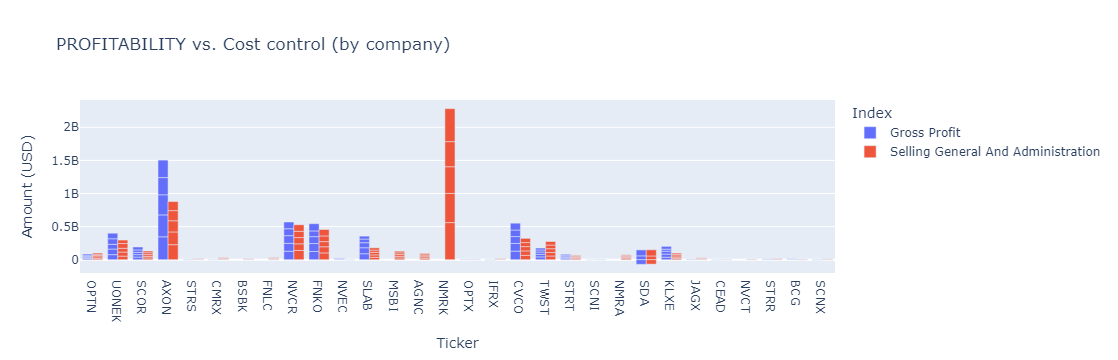

In [280]:
fig1 = px.bar(
    income,
    x='Ticker',
    y=['Gross Profit', 'Selling General And Administration'],
    barmode='group',
    title='PROFITABILITY vs. Cost control (by company)',
    labels={'value': 'Amount (USD)', 'variable': 'Index'}
)
fig1.show()

# 2.1 PROFITABILITY vs. Cost control
I choose a bar chart to horizontally compare the gross profit and sales management expenses of different companies. High gross profit but a large proportion of expenses may imply efficiency issues.Many companies have a high proportion of operating expenses, and the differences in operating and revenue levels between these companies are often significant. Therefore, directly comparing their operating amounts may not be a good choice. I chose to analyze their asset and cash flow composition to determine the operational health of this company

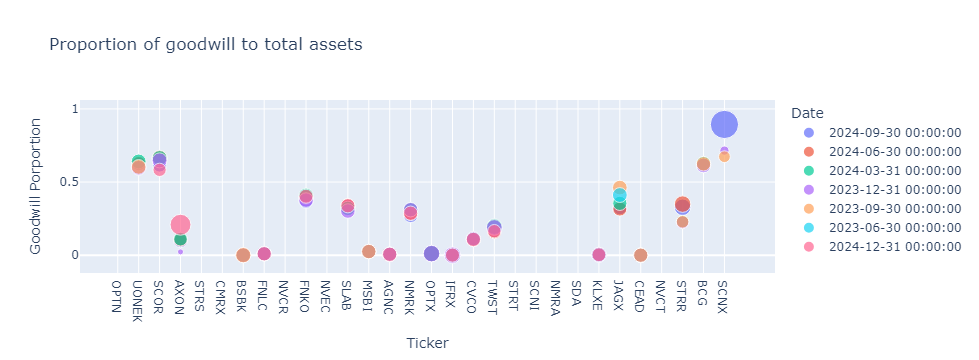

In [284]:
balance['Goodwill And Other Intangible Assets'] = balance['Goodwill And Other Intangible Assets'].fillna(0)
balance['Total Assets'] = balance['Total Assets'].fillna(0)

# Calculate the proportion of goodwill to total assets
balance['Goodwill/Assets'] = balance['Goodwill And Other Intangible Assets'] / balance['Total Assets']

# Group by Ticker and calculate the total goodwill of each Ticker
ticker_total_goodwill = balance.groupby('Ticker')['Goodwill And Other Intangible Assets'].transform('sum')

# Avoid zero denominator: Set the denominator of a company with zero total goodwill to 1 (avoid NaN), and replace it with 1 if the total goodwill is 0
ticker_total_goodwill = ticker_total_goodwill.replace(0, 1)  

# Calculate the relative proportion
balance['Goodwill_Ticker_Relative'] = (
    balance['Goodwill And Other Intangible Assets'] / ticker_total_goodwill
)

fig2 = px.scatter(
    balance,
    x='Ticker',
    y='Goodwill/Assets',
    size='Goodwill_Ticker_Relative',  
    color='Date',
    title='Proportion of goodwill to total assets ',
    labels={'Goodwill/Assets': 'Goodwill Porportion'}
)
fig2.show()

# 2.2 Proportion of goodwill to total assets
Excessive operating expenses do not necessarily mean that a company has the risk of cost control. Companies also have similar goodwill assets that can prove their potential financing ability to counter potential operating expenses. Therefore, we use scatter plots to observe which companies have a higher proportion of goodwill.Through Group by Ticker, I calculate the total goodwill of each Ticker, and then calculate the proportion of goodwill for each year to observe whether the proportion of goodwill assets has significantly decreased or increased during this period

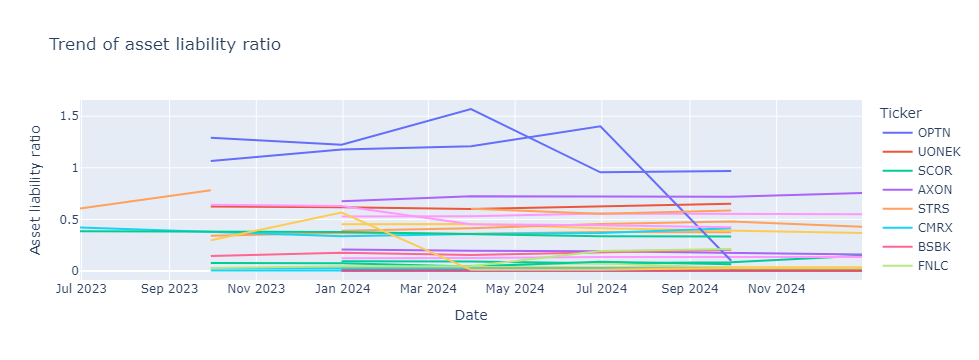

In [286]:
# Calculate the asset liability ratio
balance['Debt/Assets Ratio'] = balance['Total Debt'] / balance['Total Assets']
balance['Net Debt/Equity'] = balance['Net Debt'] / balance['Stockholders Equity']

fig3 = px.line(
    balance,
    x='Date',
    y='Debt/Assets Ratio',
    color='Ticker',
    title='Trend of asset liability ratio',
    labels={'Debt/Assets Ratio': 'Asset liability ratio'}
)
fig3.show()

# 2.3 'Trend of asset liability ratio
I calculated the asset liability ratio of each company by dividing debt by assets, and arranged them horizontally in chronological order to analyze whether there were significant changes in the asset liability ratio during the statistical period.The asset liability ratio of SCNI has decreased rapidly, which is why it will be included in my next analysis

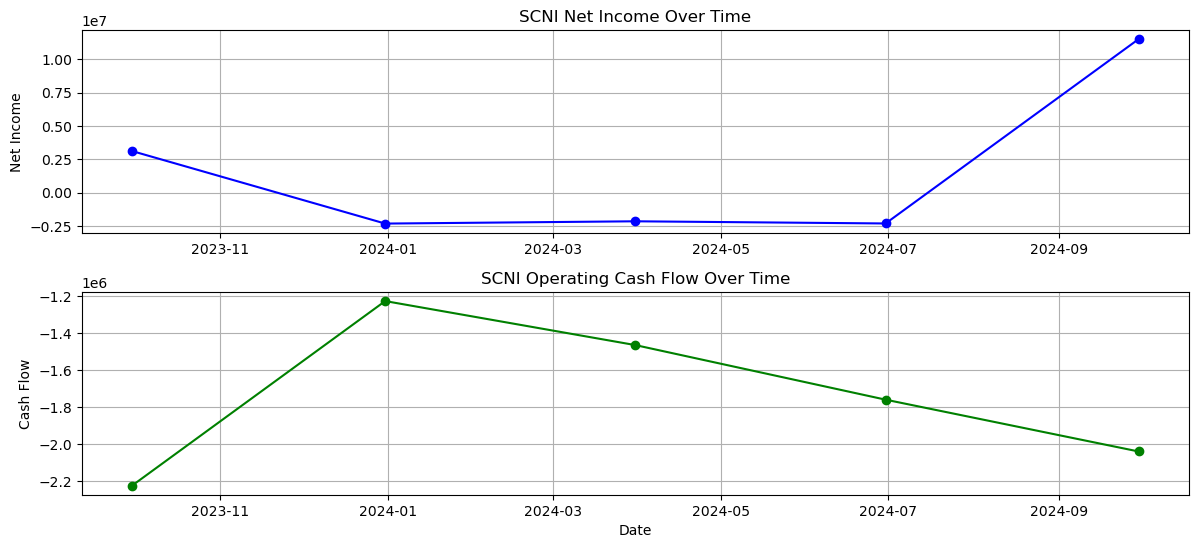

In [445]:
import pandas as pd
import matplotlib.pyplot as plt

# load data on SCNI
file_path = "nasdaq_30_combined_cleaned.xlsx"
balance = pd.read_excel(file_path, sheet_name="Balance_Sheet")
cashflow = pd.read_excel(file_path, sheet_name="Cash_Flow")
scni_balance = balance[balance["Ticker"] == "SCNI"]
scni_cashflow = cashflow[cashflow["Ticker"] == "SCNI"]

# Calculate the net profit from continuing operations (increase in total assets)
net_income = scni_cashflow[["Date", "Net Income From Continuing Operations"]]

# Cash flow from operating activities (supporting debt repayment or asset growth)
operating_cashflow = scni_cashflow[["Date", "Operating Cash Flow"]]

plt.figure(figsize=(12, 8))


# Trend of profit
plt.subplot(3, 1, 2)
plt.plot(net_income["Date"], net_income["Net Income From Continuing Operations"], marker="o", color="blue")
plt.title("SCNI Net Income Over Time")
plt.ylabel("Net Income")
plt.grid(True)

# Trend of operating cost
plt.subplot(3, 1, 3)
plt.plot(operating_cashflow["Date"], operating_cashflow["Operating Cash Flow"], marker="o", color="green")
plt.title("SCNI Operating Cash Flow Over Time")
plt.xlabel("Date")
plt.ylabel("Cash Flow")
plt.grid(True)

plt.tight_layout()
plt.show()

# 2.4 Cash control ability
Ahe asset liability ratio is usually determined by the profitability and cost of a company. I compared the profit trend and cost control trend of SCNI to identify the underlying reasons for the decline in the asset liability r.But it still needs to be compared whether it has stickiness to shareholders and whether it really invests costs in the work environment ,to check if these changes are made for long term.atio

In [471]:
from IPython.display import display

# Extract the required columns
Keymetrics = scni_cashflow[['Date', 'Free Cash Flow', 'Operating Cash Flow', 
                            'Change In Working Capital', 'Depreciation Amortization Depletion', 
                            'Cash Dividends Paid']]

# Define color rule function (only marking negative values as red)
def color_negative_red(val):
    color = 'red' if val < 0 else 'black'  
    return f'color: {color}'

# apply
styled_table = Keymetrics.style\
    .format({
        'Date': lambda x: x.strftime("%Y-%m-%d"),  # Format date and currency
        'Free Cash Flow': '${:,.0f}',              
        'Operating Cash Flow': '${:,.0f}',         
        'Change In Working Capital': '${:,.0f}',   
        'Depreciation Amortization Depletion': '${:,.0f}',  
        'Cash Dividends Paid': '${:,.0f}'        
    })\
    .applymap(color_negative_red, subset=['Cash Dividends Paid','Change In Working Capital', 'Operating Cash Flow'])  # Color label the destination of funds and dividends

display(styled_table)

C:\Users\13234\AppData\Local\Temp\ipykernel_52988\2479595804.py:23: FutureWarning:

Styler.applymap has been deprecated. Use Styler.map instead.



,Date,Free Cash Flow,Operating Cash Flow,Change In Working Capital,Depreciation Amortization Depletion,Cash Dividends Paid
128,2024-09-30,"$-2,042,000","$-2,038,000","$-280,000","$498,000","$-20,908,986"
129,2024-06-30,"$-1,764,000","$-1,758,000","$-303,000","$496,000","$-20,908,986"
130,2024-03-31,"$-1,465,000","$-1,463,000","$220,000","$156,000","$-20,908,986"
131,2023-12-31,"$-1,459,000","$-1,225,000","$14,000","$84,000","$-20,908,986"
132,2023-09-30,"$-2,242,000","$-2,222,000","$-427,000","$145,000","$-20,908,986"


# 2.5 Details of fund allocation
After analyzing the funding trends of SCNI, I selected five more segmented categories of funding flows to examine the specific numbers. I directly selected from the previously defined table, using the date as the first column, and used red and black colors on three items to distinguish positive and negative numbers, in order to make better judgments.It can be seen that the consumption of working capital has surged ,and the Dividends remained the same amount.

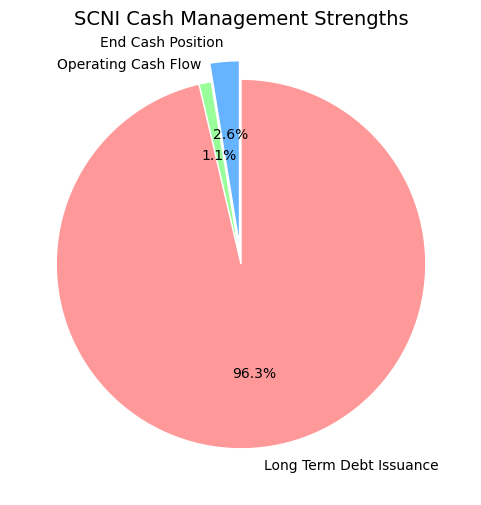

In [475]:

import matplotlib.pyplot as plt

end_cash = abs(scni_cashflow["End Cash Position"].sum())
operating_cash = abs(scni_cashflow["Operating Cash Flow"].sum())
long_debt_issuance = abs(scni_cashflow["Long Term Debt Issuance"].sum())

# set labels and values
labels = ['End Cash Position', 'Operating Cash Flow', 'Long Term Debt Issuance']
values = [end_cash, operating_cash, long_debt_issuance]
# set color and effect
colors = ['#66b3ff', '#99ff99', '#ff9999']
explode = (0.1, 0, 0)  #Highlight the ending cash balance

#Draw a pie chart
plt.figure(figsize=(6, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%',
        colors=colors, explode=explode, startangle=90,
        wedgeprops={'edgecolor': 'white'})

plt.title('SCNI Cash Management Strengths', fontsize=14)
plt.show()

# 2.6 Financial risk bearing ability
After analyzing the flow of funds, I wanted to assess the company's ability to withstand risks, so I introduced a long term debt issue outside of operating cash to observe its fund composition. As it was to observe the proportion of fund composition, I chose a pie chart.It can be seen that long term debt occupies a very exaggerated proportion

# 3 Analysis of results

The thirty companies on NASDAQ undoubtedly have strong operational capabilities, but their management and financial styles are also different.
I first calculated the proportion of SG&A costs to the company's gross profit, in order to analyze whether the operating costs of the company are too high and whether there is a risk of cost control. It can be seen that the operating costs of most enterprises occupy a significant proportion, and some even exceed gross profit. The company has different funding strategies for high operating costs ,goodwill asset is one of the most important indicator. Next, I calculated the proportion of a company's goodwill assets to determine whether the company has potential commercial and financing potential to cope with high operating costs. It can be seen that except for a few companies such as AXON, SCNX， The proportion of goodwill in most companies is less than 0.5, and there has been no significant change during the statistical period.
In order to verify the specific operational risks of these companies, I used a line chart to list their asset liability ratios. I soon found that SCNI's asset liability ratio had significantly decreased within a quarter,Its asset liability ratio has decreased from 1.4 to 0.1, and I want to know how this company achieved this.
After comparing the trends of net income and operating cash, I found that SCNI's revenue continues to rise while operating expenses continue to decline, indicating that it has taken action to address its high debt to asset ratio. But it still needs to be compared whether it has stickiness to shareholders and whether it really invests costs in the work environment. The following table proves this point. It did not infringe on the rights of shareholders and continued to invest in working capital, which made its efforts effective
In the future, whether SCNI can maintain a low debt to asset ratio without losing control of operating costs needs to be compared with its issuance of long-term bonds. Therefore, I created a pie chart and found that its long-term bond ratio is very high, up to 96%, which makes it have a high repayment demand in the future and is likely to exceed its ability to bear it
